Import all the packages that we need during the project

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import copy
import math

Let's start by loading the dataset for this task and visualizing it

In [114]:
def load_data(filename):
    data = np.loadtxt(filename, delimiter=',')
    X = data[:,:2]
    y = data[:,2]
    return X, y

In [115]:
# load dataset
X_train, y_train = load_data("data/data_nonlinear.txt")

Let's split data into training set and test set

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X_train,y_train,test_size=0.3, random_state=1)

The following code shows the dimensions of training and test sets

In [117]:
print ('The shape of X_train is: ' + str(X_train.shape))
print ('The shape of y_train is: ' + str(y_train.shape))
print ('The shape of X_train is: ' + str(X_test.shape))
print ('The shape of y_train is: ' + str(y_test.shape))
print ('We have m = %d training examples' % (len(y_train)))

The shape of X_train is: (82, 2)
The shape of y_train is: (82,)
The shape of X_train is: (36, 2)
The shape of y_train is: (36,)
We have m = 82 training examples


Before starting to implement any algorithm it is a good idea to visualize dataset. The code below displays the data on 2D plot, where the axes are two tests and positive and negative examples are shown with different colors. We define function plot_data to display the plot

In [118]:
def plot_train_data(X, y, pos_label="Accepted train", neg_label="Rejected train"):
    positive = y == 1
    negative = y == 0
    
    # Plot examples
   
    plt.plot(X_train[positive, 0], X_train[positive, 1], 'k+', label=pos_label)
    plt.plot(X_train[negative, 0], X_train[negative, 1], 'ko', label=neg_label)

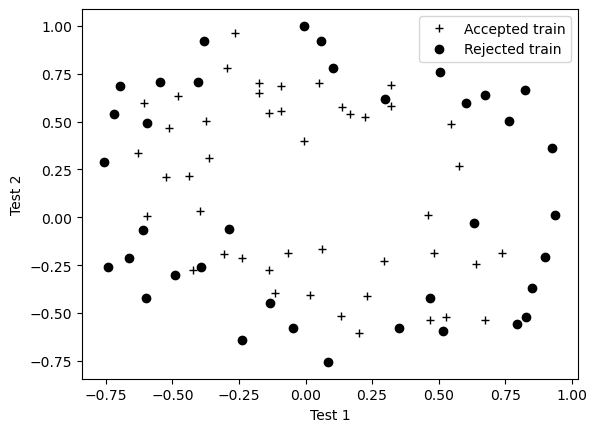

In [119]:
# Plot examples
plot_train_data(X_train, y_train)

# Set the y-axis label
plt.ylabel('Test 2') 
# Set the x-axis label
plt.xlabel('Test 1') 
plt.legend(loc="upper right")
plt.show()

<a name="3.3"></a>
### Feature mapping

One way to fit the data better is to create more features from each data point. In the provided function `map_feature`, we will map the features into all polynomial terms of $x_1$ and $x_2$ up to the sixth power.

$$\mathrm{map\_feature}(x) = 
\left[\begin{array}{c}
x_1\\
x_2\\
x_1^2\\
x_1 x_2\\
x_2^2\\
x_1^3\\
\vdots\\
x_1 x_2^5\\
x_2^6\end{array}\right]$$

As a result of this mapping, our vector of two features (the scores on two QA tests) has been transformed into a 27-dimensional vector. 

- A logistic regression classifier trained on this higher-dimension feature vector will have a more complex decision boundary and will be nonlinear when drawn in our 2-dimensional plot. 

While the feature mapping allows us to build a more expressive classifier, it is also more susceptible to overfitting. In the next parts of the exercise, we will implement regularized logistic regression to fit the data and also how regularization can help combat the overfitting problem.

In [120]:
def map_feature(X1, X2):
    """
    Feature mapping function to polynomial features    
    """
    X1 = np.atleast_1d(X1)
    X2 = np.atleast_1d(X2)
    degree = 6
    out = []
    for i in range(1, degree+1):
        for j in range(i + 1):
            out.append((X1**(i-j) * (X2**j)))
    return np.stack(out, axis=1)

In [121]:
print("Original shape of data:", X_train.shape)

mapped_X =  map_feature(X_train[:, 0], X_train[:, 1])
print("Shape after feature mapping:", mapped_X.shape)

Original shape of data: (82, 2)
Shape after feature mapping: (82, 27)


In [122]:
print("X_train[0]:", X_train[0])
print("mapped X_train[0]:", mapped_X[0])

X_train[0]: [-0.17339  0.64839]
mapped X_train[0]: [-1.73390000e-01  6.48390000e-01  3.00640921e-02 -1.12424342e-01
  4.20409592e-01 -5.21281293e-03  1.94932567e-02 -7.28948192e-02
  2.72589375e-01  9.03849634e-04 -3.37993578e-03  1.26392327e-02
 -4.72642718e-02  1.76744225e-01 -1.56718488e-04  5.86047064e-04
 -2.19151656e-03  8.19515209e-03 -3.06456812e-02  1.14599188e-01
  2.71734186e-05 -1.01614700e-04  3.79987056e-04 -1.42095742e-03
  5.31365466e-03 -1.98703532e-02  7.43049676e-02]


In [123]:
# UNQ_C1
# GRADED FUNCTION: sigmoid

def sigmoid(z):
    """
    Compute the sigmoid of z

    Args:
        z (ndarray): A scalar, numpy array of any size.

    Returns:
        g (ndarray): sigmoid(z), with the same shape as z
         
    """
          
    ### START CODE HERE ### 
    g = 1/(1+np.exp(-z))
    ### END SOLUTION ###  
    
    return g

Cost function for regularized logistic regression

In this part, we will implement the cost function for regularized logistic regression.

The for regularized logistic regression, the cost function is of the form
$$J(\mathbf{w},b) = \frac{1}{m}  \sum_{i=0}^{m-1} \left[ -y^{(i)} \log\left(f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) \right] + \frac{\lambda}{2m}  \sum_{j=0}^{n-1} w_j^2$$

The difference between the costs without regularization and regularization with is the regularization term, which is $$\frac{\lambda}{2m}  \sum_{j=0}^{n-1} w_j^2$$ 
The $b$ parameter is not regularized.

In [124]:
# UNQ_C2
# GRADED FUNCTION: compute_cost
def compute_cost(X, y, w, b, lambda_= 1):
    """
    Computes the cost over all examples
    Args:
      X : (ndarray Shape (m,n)) data, m examples by n features
      y : (array_like Shape (m,)) target value 
      w : (array_like Shape (n,)) Values of parameters of the model      
      b : scalar Values of bias parameter of the model
      lambda_: unused placeholder
    Returns:
      total_cost: (scalar)         cost 
    """

    m, n = X.shape
    
    ### START CODE HERE ###
    cost = 0
    for i in range(m):
        z = np.dot(X[i],w) + b
        f_wb = sigmoid(z)
        cost += -y[i]*np.log(f_wb) - (1-y[i])*np.log(1-f_wb)
    total_cost = cost/m
    
    ### END CODE HERE ### 

    return total_cost

In [125]:
# UNQ_C5
def compute_cost_reg(X, y, w, b, lambda_ = 1):
    """
    Computes the cost over all examples
    Args:
      X : (array_like Shape (m,n)) data, m examples by n features
      y : (array_like Shape (m,)) target value 
      w : (array_like Shape (n,)) Values of parameters of the model      
      b : (array_like Shape (n,)) Values of bias parameter of the model
      lambda_ : (scalar, float)    Controls amount of regularization
    Returns:
      total_cost: (scalar)         cost 
    """

    m, n = X.shape
    
    # Calls the compute_cost function that you implemented above
    cost_without_reg = compute_cost(X, y, w, b) 
    
    # You need to calculate this value
    reg_cost = 0.
    
    ### START CODE HERE ###
    reg_cost = sum(np.square(w))
    ### END CODE HERE ### 
    
    # Add the regularization cost to get the total cost
    total_cost = cost_without_reg + (lambda_/(2 * m)) * reg_cost

    return total_cost

Gradient for regularized logistic regression

In this section, we will implement the gradient for regularized logistic regression.


The gradient of the regularized cost function has two components. The first, $\frac{\partial J(\mathbf{w},b)}{\partial b}$ is a scalar, the other is a vector with the same shape as the parameters $\mathbf{w}$, where the $j^\mathrm{th}$ element is defined as follows:

$$\frac{\partial J(\mathbf{w},b)}{\partial b} = \frac{1}{m}  \sum_{i=0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})  $$

$$\frac{\partial J(\mathbf{w},b)}{\partial w_j} = \left( \frac{1}{m}  \sum_{i=0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}) x_j^{(i)} \right) + \frac{\lambda}{m} w_j  \quad\, \mbox{for $j=0...(n-1)$}$$

If we this to the gradient of the cost function without regularization (which you implemented above), which is of the form 
$$
\frac{\partial J(\mathbf{w},b)}{\partial b}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)}) \tag{2}
$$
$$
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)})x_{j}^{(i)} \tag{3}
$$


As we can see,$\frac{\partial J(\mathbf{w},b)}{\partial b}$ is the same, the difference is the following term in $\frac{\partial J(\mathbf{w},b)}{\partial w}$, which is $$\frac{\lambda}{m} w_j  \quad\, \mbox{for $j=0...(n-1)$}$$ 



In [126]:
# UNQ_C3
# GRADED FUNCTION: compute_gradient
def compute_gradient(X, y, w, b, lambda_=None): 
    """
    Computes the gradient for logistic regression 
 
    Args:
      X : (ndarray Shape (m,n)) variable such as house size 
      y : (array_like Shape (m,1)) actual value 
      w : (array_like Shape (n,1)) values of parameters of the model      
      b : (scalar)                 value of parameter of the model 
      lambda_: unused placeholder.
    Returns
      dj_dw: (array_like Shape (n,1)) The gradient of the cost w.r.t. the parameters w. 
      dj_db: (scalar)                The gradient of the cost w.r.t. the parameter b. 
    """
    m, n = X.shape
    dj_dw = np.zeros(w.shape)
    dj_db = 0.

    ### START CODE HERE ### 
    for i in range(m):
        f_wb_i = sigmoid(np.dot(X[i],w) + b)          
        err_i  = f_wb_i  - y[i]                       
        for j in range(n):
            dj_dw[j] = dj_dw[j] + err_i * X[i,j]      
        dj_db = dj_db + err_i
    dj_dw = dj_dw/m                                   
    dj_db = dj_db/m                                   
        
    ### END CODE HERE ###

        
    return dj_db, dj_dw

In [127]:
X_mapped_train = map_feature(X_train[:, 0], X_train[:, 1])
np.random.seed(1) 
initial_w  = np.random.rand(X_mapped.shape[1]) - 0.5 
initial_b = 0.5
 
lambda_ = 0.5
dj_db, dj_dw = compute_gradient_reg(X_mapped, y_train, initial_w, initial_b, lambda_)

print(f"dj_db: {dj_db}", )
print(f"First few elements of regularized dj_dw:\n {dj_dw[:4].tolist()}", )

dj_db: 0.02484478845332021
First few elements of regularized dj_dw:
 [-0.009127476146881804, -0.0017190590292574762, 0.0434261541605323, 0.0045871429809774015]


In [128]:
X_mapped_test = map_feature(X_train[:, 0], X_train[:, 1])
np.random.seed(1) 
initial_w  = np.random.rand(X_mapped.shape[1]) - 0.5 
initial_b = 0.5
 
lambda_ = 0.5
dj_db, dj_dw = compute_gradient_reg(X_mapped, y_train, initial_w, initial_b, lambda_)

print(f"dj_db: {dj_db}", )
print(f"First few elements of regularized dj_dw:\n {dj_dw[:4].tolist()}", )

dj_db: 0.02484478845332021
First few elements of regularized dj_dw:
 [-0.009127476146881804, -0.0017190590292574762, 0.0434261541605323, 0.0045871429809774015]


In [129]:
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters, lambda_): 
    """
    Performs batch gradient descent to learn theta. Updates theta by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      X :    (array_like Shape (m, n)
      y :    (array_like Shape (m,))
      w_in : (array_like Shape (n,))  Initial values of parameters of the model
      b_in : (scalar)                 Initial value of parameter of the model
      cost_function:                  function to compute cost
      alpha : (float)                 Learning rate
      num_iters : (int)               number of iterations to run gradient descent
      lambda_ (scalar, float)         regularization constant
      
    Returns:
      w : (array_like Shape (n,)) Updated values of parameters of the model after
          running gradient descent
      b : (scalar)                Updated value of parameter of the model after
          running gradient descent
    """
    
    # number of training examples
    m = len(X)
    
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w_history = []
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db, dj_dw = gradient_function(X, y, w_in, b_in, lambda_)   

        # Update Parameters using w, b, alpha and gradient
        w_in = w_in - alpha * dj_dw               
        b_in = b_in - alpha * dj_db              
       
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            cost =  cost_function(X, y, w_in, b_in, lambda_)
            J_history.append(cost)

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters/10) == 0 or i == (num_iters-1):
            w_history.append(w_in)
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}   ")
        
    return w_in, b_in, J_history, w_history #return w and J,w history for graphing

In [130]:
# UNQ_C6
def compute_gradient_reg(X, y, w, b, lambda_ = 1): 
    """
    Computes the gradient for linear regression 
 
    Args:
      X : (ndarray Shape (m,n))   variable such as house size 
      y : (ndarray Shape (m,))    actual value 
      w : (ndarray Shape (n,))    values of parameters of the model      
      b : (scalar)                value of parameter of the model  
      lambda_ : (scalar,float)    regularization constant
    Returns
      dj_db: (scalar)             The gradient of the cost w.r.t. the parameter b. 
      dj_dw: (ndarray Shape (n,)) The gradient of the cost w.r.t. the parameters w. 

    """
    m, n = X.shape
    
    dj_db, dj_dw = compute_gradient(X, y, w, b)

    ### START CODE HERE ###     
    for j in range(n):
        dj_dw[j] = dj_dw[j] + (lambda_/m) * w[j]
    ### END CODE HERE ###         
        
    return dj_db, dj_dw

Learning parameters using gradient descent

We will use gradient descent function implemented above to learn the optimal parameters $w$,$b$. 

In [131]:
# Initialize fitting parameters
np.random.seed(1)
initial_w = np.random.rand(X_mapped.shape[1])-0.5
initial_b = 1.

# Set regularization parameter lambda_ to 1 (you can try varying this)
lambda_ = 0.01;                                          
# Some gradient descent settings
iterations = 10000
alpha = 0.01

w,b, J_history,_ = gradient_descent(X_mapped_train, y_train, initial_w, initial_b, 
                                    compute_cost_reg, compute_gradient_reg, 
                                    alpha, iterations, lambda_)

Iteration    0: Cost     0.69   


Iteration 1000: Cost     0.61   
Iteration 2000: Cost     0.58   
Iteration 3000: Cost     0.56   
Iteration 4000: Cost     0.55   
Iteration 5000: Cost     0.53   
Iteration 6000: Cost     0.52   
Iteration 7000: Cost     0.51   
Iteration 8000: Cost     0.50   
Iteration 9000: Cost     0.49   
Iteration 9999: Cost     0.48   


Plotting the decision boundary

To help us visualize the model learned by this classifier, we will use our `plot_decision_boundary` function which plots the (non-linear) decision boundary that separates the positive and negative examples. 

- In the function, we plotted the non-linear decision boundary by computing the classifier’s predictions on an evenly spaced grid and then drew a contour plot of where the predictions change from y = 0 to y = 1.

- After learning the parameters $w$,$b$, the next step is to plot a decision boundary


In [132]:
def plot_decision_boundary(w, b, X, y):
    # Credit to dibgerge on Github for this plotting code
     
    plot_train_data(X_train[:, 0:2], y_train)
    
    if X.shape[1] <= 2:
        plot_x = np.array([min(X[:, 0]), max(X[:, 0])])
        plot_y = (-1. / w[1]) * (w[0] * plot_x + b)
        
        plt.plot(plot_x, plot_y, c="b")
        
    else:
        u = np.linspace(-1, 1.5, 50)
        v = np.linspace(-1, 1.5, 50)
        
        z = np.zeros((len(u), len(v)))

        # Evaluate z = theta*x over the grid
        for i in range(len(u)):
            for j in range(len(v)):
                z[i,j] = sig(np.dot(map_feature(u[i], v[j]), w) + b)
        
        # important to transpose z before calling contour       
        z = z.T
        
        # Plot z = 0
        plt.contour(u,v,z, levels = [0.5], colors="g")

In [133]:
def sig(z):
    return 1/(1+np.exp(-z))

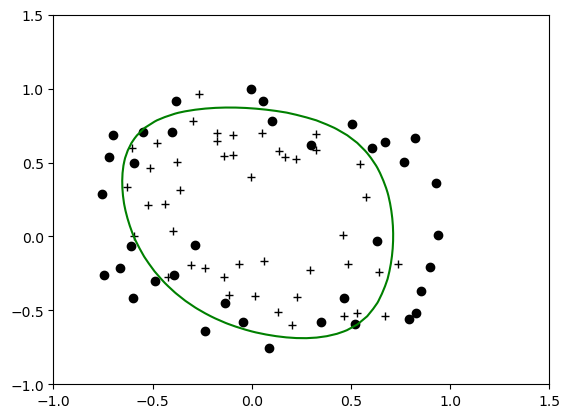

In [134]:
plot_decision_boundary(w, b, X_mapped_train, y_train)

Evaluating regularized logistic regression model

We will use the `predict` function to calculate the accuracy of the regulaized logistic regression model on the training set

In [135]:
# UNQ_C4
# GRADED FUNCTION: predict

def predict(X, w, b): 
    """
    Predict whether the label is 0 or 1 using learned logistic
    regression parameters w
    
    Args:
    X : (ndarray Shape (m, n))
    w : (array_like Shape (n,))      Parameters of the model
    b : (scalar, float)              Parameter of the model

    Returns:
    p: (ndarray (m,1))
        The predictions for X using a threshold at 0.5
    """
    # number of training examples
    m, n = X.shape   
    p = np.zeros(m)
   
    ### START CODE HERE ### 
    # Loop over each example
    for i in range(m):   
        z_wb = np.dot(X[i],w) 
        # Loop over each feature
        for j in range(n): 
            # Add the corresponding term to z_wb
            z_wb += 0
        
        # Add bias term 
        z_wb += b
        
        # Calculate the prediction for this example
        f_wb = sigmoid(z_wb)

        # Apply the threshold
        p[i] = 1 if f_wb>0.5 else 0
        
    ### END CODE HERE ### 
    return p

In [136]:
#Compute accuracy on the training set
p = predict(X_mapped_test, w, b)

print('Train Accuracy: %f'%(np.mean(p == y_test) * 100))

Train Accuracy: 0.000000


C:\Users\User\AppData\Local\Temp\ipykernel_9240\31551396.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  print('Train Accuracy: %f'%(np.mean(p == y_test) * 100))


Now, we can add test data to training data with decision boundary

In [137]:
def plot_test_data(X, y, pos_label="Accepted test", neg_label="Rejected test"):
    positive = y == 1
    negative = y == 0
    
    # Plot examples
   
    plt.plot(X_test[positive, 0], X_test[positive, 1], 'r+', label=pos_label)
    plt.plot(X_test[negative, 0], X_test[negative, 1], 'ro', label=neg_label)

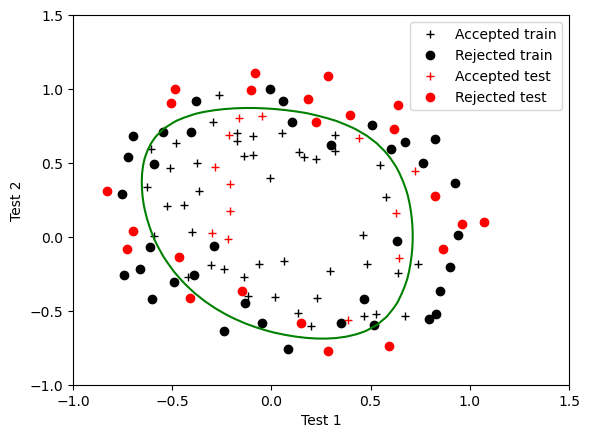

In [138]:
plot_decision_boundary(w, b, X_mapped_train, y_train)

plot_test_data(X_test, y_test)

# Set the y-axis label
plt.ylabel('Test 2') 
# Set the x-axis label
plt.xlabel('Test 1') 
plt.legend(loc="upper right")
plt.show()